# Instructions

Choose `Runtime -> Restart and Run All` in the menu, and then scroll down to the **Simple Calculator** section.

Unfortunately, it will take a while to install some packages. 



In [ ]:
!pip install -q git+https://github.com/danzimmerman/n3ox_utils.git

     |████████████████████████████████| 1.6MB 3.4MB/s 


In [ ]:
#!pip install PyNEC==1.7.3.4

In [ ]:
#import PyNEC as pynec

In [ ]:
#@title
import plotly.graph_objects as go
import sympy as sp
import numpy as np
import numba as nm
import scipy.integrate
import matplotlib.pyplot as plt
import n3ox_utils.pynec_helpers as pnh
import n3ox_utils.plot_tools as ptl 

plt = ptl.init_pyplot_defaults(plt)

import cycler 
%matplotlib inline
from scipy.constants import speed_of_light, foot
from IPython.display import display, clear_output, HTML
from matplotlib.animation import FuncAnimation
import os
import ipywidgets as ipw

from pprint import pprint
import sys

from google.colab import files as gcfiles
import json

In [ ]:
class ArrayOptimizer(object):
    """
    Object-oriented interface for M.T. Ma's Array Optimization, by N3OX.

    At the moment, it will only compute B once when it's initialized.
    """
    def __init__(self, wires, freq_MHz, textarea=None):
        """
        Initialize the solver with a list of wire dictionary from 
        WireInput.return_wire_dicts from n3ox_utils.pynec_helpers

        The z-coordinates are not used. Please build arrays in the x-y plane!
        """
        self.wires = wires
        self.textarea = textarea
        self.nwires = len(self.wires)
        self.elx = np.zeros([self.nwires, ])
        self.ely = np.zeros([self.nwires, ])
        self.freq = freq_MHz
        self.wl = (speed_of_light/(self.freq*1e6)) #wavenumber in meters
        self.k = 2*np.pi/self.wl

        for n, wire in enumerate(self.wires):
            self.elx[n] = (wire['xw1']+wire['xw2'])/2.0
            self.ely[n] = (wire['yw1']+wire['yw2'])/2.0

        self.B = self._computeB() #this is expensive to compute so we do it here and save it.
        self.Binv = np.linalg.inv(self.B)

    def _blmnum_integrand(self, th, phi, xl, xm, yl, ym):
        """
        Function to compute the integrand of the matrix element b_{lm}
        """
        return (1/(4*np.pi)*np.power(np.sin(th), 2)
                *np.exp(-1j*( #1j or -1j?
                            self.k*(xl-xm)*np.sin(th)*np.cos(phi)
                            +self.k*(yl-ym)*np.sin(th)*np.sin(phi)
                            )
                        )
                )
    
    def _blmnum(self, xl, xm, yl, ym):
        '''
        Returns the complex matrix element b_{lm}.
        '''
        rlprt = scipy.integrate.nquad(lambda th, ph: np.real(self._blmnum_integrand(th, ph, xl, xm, yl, ym))*np.sin(th), 
                                        [(0, np.pi), (0, 2*np.pi)])
        imprt = scipy.integrate.nquad(lambda th, ph: np.imag(self._blmnum_integrand(th, ph, xl, xm, yl, ym))*np.sin(th), 
                                        [(0, np.pi), (0, 2*np.pi)])
        return rlprt[0]+1j*imprt[0]
    
    def _computeB(self):
        B = np.zeros([self.nwires, self.nwires] ,dtype=np.complex_)
        for l in nm.prange(0, self.nwires):
            xl = self.elx[l]
            yl = self.ely[l]
            for m in range(0, self.nwires):
                xm = self.elx[m]
                ym = self.ely[m]
                if self.textarea:
                    pstring = 'ArrayOptimizer() computing B:\n\tWorking on B[{0},{3}]\n\tElements at ({1:.2f}, {2:.2f})'
                    pstring += ' and ({4:.2f}, {5:.2f})...'
                    self.textarea.value = pstring.format(l+1,xl,yl,m+1,xm,ym)
                B[l, m] = self._blmnum(xl, xm, yl, ym)
        self.textarea.value += '\n\t... done! '
        return B

    def evec(self, az, el):
        """
        Compute a single e vector given a single elevation and azimuth angle in degrees.
        """
        evec = np.zeros(self.nwires, dtype=np.complex_)
        th0r = (90-el)*np.pi/180.0
        ph0r = az*np.pi/180.0
        evec = np.exp(1j*(self.k*self.elx*np.sin(th0r)*np.cos(ph0r)+self.k*self.ely*np.sin(th0r)*np.sin(ph0r)))
        return evec   

    def iopt(self, az, el, normalize=True):
        """
        Compute the complex optimal current for a given elevation and azimuth in degrees.
        """      
        iopt = self.Binv@self.evec(az, el)
        if normalize:
            iopt /= np.max(np.abs(iopt))
        return iopt

class SimpleIoptCalc(object):
    """
    A simple IPyWidgets GUI to compute the optimal currents.
    """
    def __init__(self):
        self.ao = None
        self.layout = ipw.Layout(width='100%')
        
        self.freqbox = ipw.BoundedFloatText(description='f (MHz)', value=1.83, min=0.1, max=10000)
        self.freqbox.observe(self.on_freq_change)
        self.Bbutton = ipw.Button(description='Compute B', 
                                    button_style='info',
                                    tooltip='Recompute with new frequency or wire geometry.')
        self.Bbutton.on_click(self.on_click_compute_B)

        self.savebutton = ipw.Button(description='Save JSON', button_style='info',
                                     tooltip='Save description (widget state) as JSON')
        self.loadbutton = ipw.Button(description='Load JSON', button_style='info',
                                     tooltip='Load description (widget state) as JSON',
                                     disabled=True)
        
        self.savebutton.on_click(self.on_JSON_save)
        self.loadbutton.on_click(self.on_JSON_load)
        self.jsontext = ipw.Text(description='Load FN',
                                 tooltip='Name of JSON file to load. Use sidebar upload!')
        self.jsontext.observe(self.on_JSON_file)
        self.firstrow = ipw.HBox([self.Bbutton, self.freqbox, self.savebutton, 
                                  self.loadbutton, self.jsontext], 
                                 layout=self.layout)
        
        self.azslider = ipw.FloatSlider(description='Az (deg)',
                                        min=-180, max=180, value=0, step=1)
        self.azslider.observe(self.on_slider_change)
        self.elslider = ipw.FloatSlider(description='El (deg)',
                                        min=-90, max=90, value=0, step=1)
        self.elslider.observe(self.on_slider_change)
        self.init_status_value = 'Click "Compute B" to begin...'
        self.statustext = ipw.Textarea(description='Status', value=self.init_status_value, 
                                       layout=ipw.Layout(width='50%', height='75px'), disabled=False)
        self.currtext = ipw.Textarea(description='Currents', value='', 
                                     layout=ipw.Layout(width='50%', height='250px'), disabled=False)

        self.header = ipw.Label(value='\nAdjust wires and frequency and then click "Compute B" or "Recompute B", then compute currents with az/el sliders.')
        self.widgetgroup = ipw.VBox([self.header,
                                     self.firstrow, 
                                     self.azslider, 
                                     self.elslider,
                                     self.statustext, 
                                     self.currtext])
    def reset(self, statusval=None):
        """
        Reset to initial state.
        """
        if not statusval:
            statusval = self.init_status_value
        self.statustext.value = statusval
        self.Bbutton.description = 'Compute B'
        self.currtext.value = ''
        self.ao = None

    def on_freq_change(self, change):
        """
        Reset the widget set if the frequency changes.
        """
        self.reset()

    def on_click_compute_B(self, button):
        """
        Callback for the matrix compute button.
        """
        self.ao = ArrayOptimizer(wireinput.return_wire_dicts(), self.freqbox.value, 
                                 textarea=self.statustext)
        self.Bbutton.description = 'Recompute B'
        self.currtext.value = 'Adjust sliders to compute optimal currents...'
        self.on_slider_change({})
    
    def on_JSON_file(self, change):
        """
        Handles jsontext
        """
        fn = self.jsontext.value
        if not fn.lower().count('.json'):
            self.loadbutton.disabled = True
            self.statustext.value = '**Error: description to load should have .json extension...'
        else:
            try:
                with open(fn, 'r') as jsf:
                    _ = json.load(jsf)
                self.loadbutton.disabled = False
                self.statustext.value = f'Click "Load JSON" to load {fn}'
            except:
                self.loadbutton.disabled = True
                self.statustext.value = f'Can\'t find {fn}. Did you upload in sidebar?'

    def on_JSON_load(self, button):
        """
        Uploads widget state/antenna description as JSON.
        """
        self.statustext.value = 'Loading JSON description...'
        try:   
            fn = self.jsontext.value    
            with open(fn, 'r') as jsf:
                jsdict = json.load(jsf)
            self.jsd = jsdict
            wireinput.delete_all_wires()
            for wd in jsdict['wires']:
                row = wireinput.add_wire_row()
                wireinput.populate_row(row=row, wiredict=wd)
            wireinput.refresh()
            self.reset()
            self.freqbox.value = self.jsd['freq']
            self.azslider.value = self.jsd['az']
            self.elslider.value = self.jsd['el']
        except Exception as e:
            print(e)
            self.statustext.value += '\n... **ERROR! Can\'t load file. Did you upload with the sidebar?'
    
    def on_JSON_save(self, button):
        """
        Downloads widget state/antenna description as JSON.
        """
        self.statustext.value = 'Saving JSON description...'
        jsdict = {}
        jsdict['wires'] = wireinput.return_wire_dicts()
        jsdict['freq'] = self.freqbox.value
        jsdict['az'] = self.azslider.value
        jsdict['el'] = self.elslider.value

        #store B and B.inverse() if they're valid
        if (not self.ao == None) and self.ao_B_is_valid():
            jsdict['B_real'] = self.ao.B.real.tolist()
            jsdict['B_imag'] = self.ao.B.imag.tolist()
            jsdict['Binv_real'] = self.ao.Binv.real.tolist()
            jsdict['Binv_imag'] = self.ao.Binv.imag.tolist()

        with open('desc.json', 'w') as jsf:
            json.dump(jsdict, jsf, indent=2)
        gcfiles.download('desc.json')
    
    def ao_B_is_valid(self):
        """
        Checks to make sure that the wire input widget's wires match the 
        ArrayOptimizer's internal wires and the frequencies match.

        if ao == None returns false
        """
        if not self.ao:
            return False
        else:
            valid = True
            valid &= (self.ao.nwires == wireinput.nwires)
            for wdin, wdcalc in zip(wireinput.return_wire_dicts(), self.ao.wires):
                valid &= (wdin == wdcalc)
            valid &= (self.freqbox.value == self.ao.freq)
            return valid

    def on_slider_change(self, change):
        """
        Handles the azimuth and elevation slider changes.
        """
        azel_str = 'Az {0:.3f} deg, El {1:.3f} deg'
        az = self.azslider.value
        el = self.elslider.value
        self.currtext.value = azel_str.format(az, el)
        if not self.ao:
            self.currtext.value += '\n**Error: Uninitialized B, can\'t compute currents...'
        else:
            ok_to_calc = self.ao_B_is_valid()
            if not ok_to_calc:
                self.reset(statusval='**Error: Found mismatch between WireInput wires and stored ArrayOptimizer wires... Press "Compute B"')
            else:
                ev = self.ao.evec(az, el)
                Dcplx = ev.T.conj()@self.ao.Binv@ev
                DdB = 10*np.log10(Dcplx.real)
                self.currtext.value += f'\nDmax = {DdB:.2f}dB'
                self.currtext.value += '\nSrc # : mag (A) | phase (deg)\n\n'
                currents = self.ao.iopt(az, el, normalize=True)
                istr = 'Src #{0}: {1:.6f} | {2:.6f}'
                for nc, current in enumerate(currents):
                    #self.currtext.value += f'{current.real:6.6f} + j {current.imag:6.6f}\n'
                    self.currtext.value += istr.format(nc+1, np.abs(current), np.angle(current, deg=True))
                    self.currtext.value += '\n'

    
    def show(self):
        """
        Display the widgets.
        """
        display(self.widgetgroup)




# Simple Calculator

Use the wire input interface below to add wires. When satisfied, enter the frequency and click "Calculate B".

Once the matrix $\mathbf{B}$ is calculated (see background below), the azimuth and elevation sliders (or their textboxes) can be used to quickly compute the optimal currents. 

The calculator only uses the `(x, y)` coordinates of presumed-vertical infintesimal dipole elements all in one plane. Therefore, the z-coordinates of both ends of the wire are arbitrary and have no effect on the calculation, and the x-coordinate and y-coordinate should be the same at both ends of each wire. 

## Saving your Work

**WARNING:** Saving the **notebook** does NOT save the `WireInput()` or other calculator widget states. Use `Save JSON` to download the description in `.json` format.

## Loading a saved `.json`

Uploading a JSON file reliably for now is awkward. This requires the user to manually upload the file using the Google Colab sidebar to the left.


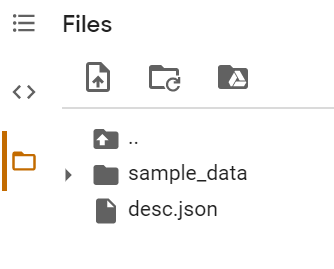

Please upload your description file using the sidebar interface and type its filename into the `Load FN` box before clicking `Load JSON`.

Work in progress.

In [ ]:
figs = {}
ARRAY = '20m_11circ'#'lee', 'm0agp', etc 
from types import SimpleNamespace
def Rm(a):
    """
    2D rotation matrix
    """
    return np.array([[np.cos(a), -np.sin(a)],
                       [np.sin(a), np.cos(a)]]) 
if ARRAY == 'lee':
    la = SimpleNamespace()
    la.Ro = 250*foot
    la.Ri = 125*foot
    la.No = 9
    la.Ni = 5
    la.tho = np.linspace(0, 2*np.pi, la.No, endpoint=False)
    la.thi = np.linspace(0, 2*np.pi, la.Ni, endpoint=False)
    la.xo = la.Ro*np.cos(la.tho)
    la.yo = la.Ro*np.sin(la.tho)
    la.xi = la.Ri*np.cos(la.thi)
    la.yi = la.Ri*np.sin(la.thi)

    # find indices by 
    la.rangs = np.array([0, 30])
    la.rarad = np.pi/180 * la.rangs
    la.Rms = [Rm(a) for a in la.rarad]
    la.ixos = []
    la.ixis = []
    for Rm in la.Rms:
        xtor, ytor = Rm@np.vstack([la.xo, la.yo])
        la.ixos.append(ytor>=-10)
        xtir, ytir = Rm@np.vstack([la.xi, la.yi])
        la.ixis.append(ytir>=-10)
    la.ixos.append(np.ones(la.xo.shape, dtype=bool))
    la.ixis.append(np.ones(la.xi.shape, dtype=bool))
    figs[1] = plt.figure(figsize=(15, 5))
    (figs[1].axa, figs[1].axb, figs[1].axc) = figs[1].subplots(1, 3) #, (figs[1].axc, figs[1].axd)
    popts = dict(linestyle='None', marker='o', color='k')
    npopts = dict(linestyle='None', marker='o', color='#CCCCCC')
    
    for ax, ixo, ixi, axl in zip(figs[1].axes, la.ixos, la.ixis, ['Array A', 'Array B', 'Full']):
        for x, y, ix in zip([la.xo, la.xi], [la.yo, la.yi], [ixo, ixi]):
            ax.plot(x[ix]/foot, y[ix]/foot, **popts)
            ax.plot(x[~ix]/foot, y[~ix]/foot, **npopts)
        ax.axis('equal')
        ax.set_title(axl, fontsize=16)
        ax.grid()
    #figs[1].tight_layout()
else:
    la = SimpleNamespace()
    la.Ro = 9
    la.No = 11
    la.tho = np.linspace(0, 2*np.pi, la.No, endpoint=False)
    la.xo = la.Ro*np.cos(la.tho)
    la.yo = la.Ro*np.sin(la.tho)
    la.xi = la.xo
    la.yi = la.yo
    la.ixos = [np.ones(la.xo.shape, dtype=bool)]
    la.ixis = [np.zeros(la.xo.shape, dtype=bool)]


In [ ]:
# ================================= Create and Display Widgets ==============================
wireinput = pnh.WireInput()
#wireinput.import_EZNEC_wires_from_URL('http://n3ox.net/files/ezwires/m0agp_20m_8circ_wires.txt', round=6)
wireinput.delete_all_wires()
CFGN = 0
ixo = la.ixos[CFGN]
ixi = la.ixis[CFGN]
for x, y in zip(np.hstack([la.xo[ixo], la.xi[ixi]]), 
                np.hstack([la.yo[ixo], la.yi[ixi]])):
    wd = dict(xw1=x.round(3), yw1=y.round(3), zw1=0, 
              xw2=x.round(3), yw2=y.round(3), zw2=3,
              rad=0.0125, segment_count=7)
    row = wireinput.add_wire_row()
    wireinput.populate_row(row, wd)
wireinput.show()

iocalc = SimpleIoptCalc()
iocalc.show()
iocalc.azslider.value = -90

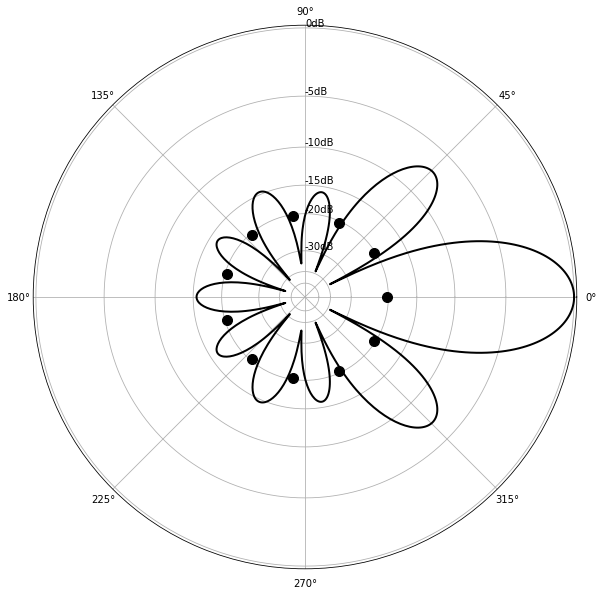

In [ ]:
# plot an azimuth pattern
fig = ptl.init_ARRL_polar_fig(plt, figsize=(10, 10))
plot_azangs = np.linspace(0, 360, 720, endpoint=True)
plot_elang = 0
#change the target angles the array is optimized for here
target_az = iocalc.azslider.value
target_el = iocalc.elslider.value
fig.axb = fig.add_axes(fig.axa.get_position(),
                       label='elplot',
                       frameon=False)
fig.axb.axis('equal')
xcoord = []
ycoord = []
for wd in wireinput.return_wire_dicts():
    xcoord.append(wd['xw1'])
    ycoord.append(wd['yw1'])

elbox = 30
fig.axb.set_xlim([-elbox, elbox])
fig.axb.set_ylim([-elbox, elbox])
sct = fig.axb.scatter(xcoord, ycoord)#, c=np.abs(multipleIopt[0]),cmap='magma',s=15)
#sct.set_clim([-2,0])
fig.axb.xaxis.set_visible(False)
fig.axb.yaxis.set_visible(False)
if not iocalc.ao:
    print('Re-run this cell after computing currents for a pattern...')
else:
    Dpow = np.zeros(plot_azangs.shape)
    Iopt = iocalc.ao.iopt(target_az, target_el)
    for i, pazang in enumerate(plot_azangs): #TODO: vectorize this!
        ev = iocalc.ao.evec(pazang, plot_elang)
        A = (ev[:, np.newaxis]@ev[:, np.newaxis].conj().T)
        
        Dcplx = (Iopt.conj().T@A@Iopt) / (Iopt.conj().T@iocalc.ao.B@Iopt)
        Dpow[i] = Dcplx.real

    ptl.add_ARRL_polar_plot(plot_azangs*np.pi/180, Dpow, ax=fig.axa)


In [ ]:
print(wireinput.get_EZNEC_wirestr())

m m
76.200000000000, 0.000000000000, 0.000000000000, 76.200000000000, 0.000000000000, 3.000000000000, 0.012500000000
58.373000000000, 48.980000000000, 0.000000000000, 58.373000000000, 48.980000000000, 3.000000000000, 0.012500000000
13.232000000000, 75.042000000000, 0.000000000000, 13.232000000000, 75.042000000000, 3.000000000000, 0.012500000000
-38.100000000000, 65.991000000000, 0.000000000000, -38.100000000000, 65.991000000000, 3.000000000000, 0.012500000000
-71.605000000000, 26.062000000000, 0.000000000000, -71.605000000000, 26.062000000000, 3.000000000000, 0.012500000000
-71.605000000000, -26.062000000000, 0.000000000000, -71.605000000000, -26.062000000000, 3.000000000000, 0.012500000000
-38.100000000000, -65.991000000000, 0.000000000000, -38.100000000000, -65.991000000000, 3.000000000000, 0.012500000000
13.232000000000, -75.042000000000, 0.000000000000, 13.232000000000, -75.042000000000, 3.000000000000, 0.012500000000
58.373000000000, -48.980000000000, 0.000000000000, 58.3730000000

# PyNEC Simulations

After a lot of trial and error, it appears that `PyNEC 1.7.3.4` can be installed on Colab. 

This section uses the solution above to compute an actual simulation.

This application really needs current sources. I think the approach I'll use is described by Owen Duffy under "Faking It" [here](https://owenduffy.net/blog/?p=3561).

## Two-Port Network

$$\begin{pmatrix}
I_1 \\ I_2
\end{pmatrix} = 
\begin{pmatrix}
Y_{11} & Y_{12} \\
Y_{21} & Y_{22}
\end{pmatrix}
\begin{pmatrix}
V_1 \\ V_2
\end{pmatrix}$$

If port 2 is connected to the element and port 1 is connected to the voltage excitation, we want $I_2$ to be controlled entirely by $V_1$. 

$$I_1 = Y_{11}V_1+Y_{12}V_2$$
$$I_2 = Y_{21}V_1+Y_{22}V_2$$

With $Y_{11} = 0, Y_{22} = 0, Y_{21}=Y_{12}=1\Omega^{-1}$

$$I_1 = 1\Omega^{-1}V_2$$
$$I_2 = 1\Omega^{-1}V_1$$

So 
$$I_2/V_1 = 1\Omega^{-1}$$
substituted into the first equation gives
$$I_1 = I_2/V_1V_2$$ 
or $$V_2I_2 = V_1I_1$$
which simply says that the power at the two ports is equal.

So maybe we want $$\begin{pmatrix}0 & 1 \\ 1 & 0\end{pmatrix}$$. It's definitely symmetric, since that's required by NEC.

[NEC NT Card](https://www.nec2.org/part_3/cards/nt.html)
`tag_p1 seg_p1 tag_p2 seg_p2 Y11R, Y11I, Y12R, Y12I, Y22R, Y22I`

Owen has `NT 9901 1 5 1 0 0 0 1` which seems to be $imag(Y_{12}) = 1$, presuming that the rest are zeroes.

[ON5AU](http://on5au.be/content/amod/amod53.html) has a lot more detail, which seems to concur with 

$$\begin{pmatrix}0 & j \\ j & 0\end{pmatrix}$$

Need to learn about two-port networks apparently.
$$I_1 = j\Omega^{-1}V_2$$
$$I_2 = j\Omega^{-1}V_1$$

In [ ]:
from types import SimpleNamespace # a container to hold attributes
array = SimpleNamespace()
array.context = pynec.nec_context()
array.geo = array.context.get_geometry()
array.wiredicts = wireinput.return_wire_dicts()
for wd in array.wiredicts:
    array.geo.wire(**wd)
    
array.context.geometry_complete(0)




In [ ]:
exargs = pnh.pack_ex_card_args(source_tag=1, source_seg=2,
                               excitation_type='voltage', 
                               ereal=48.0, eimag=0)
print(f'Args for ex_card are {exargs}')
array.context.ex_card(*exargs)

Args for ex_card are [0, 1, 2, 0, 48.0, 0, 0, 0, 0, 0]


# Background: Antenna Array Optimum Directivity
## Following: M.T. Ma, 'Theory and Application of Antenna Arrays', Wiley-Interscience 1974

`ISBN 0-471-55795-1`

This notebook computes the optimal directivity of a two-dimensional radio antenna array using M.T. Ma's algorithm presented in Chapter 3 of this book. This work was performed at the request of an acquaintance who was hoping to synthesize higher-performance arrays for long-wave radio reception on the amateur radio bands.

The current amplitudes and phases computed here show excellent performance using NEC-2 simulations. Unfortunately, these simulations also show that the arrays attempted here often show excessive sensitivity to the amplitudes and phases of the currents to make them practical for amateur use.


## 2D Geometry Definition

Note that throughout this notebook, $\theta$ denotes the co-elevation (so the typical antenna elevation angle $\psi = \pi/2-\theta$) and $\phi$ denotes the azimuth angle, with zero degrees on the x-axis.

<img src="https://www.danzimmerman.com/code/directivity/images/mt_ma_antenna_array.jpeg'" alt="Figure 3.1, Array geometry definition." width="60%"/>

_**Fig 3.1** from Ch 3: Analysis and Synthesis of Two-Dimensional Arrays (p187)_

The array here is defined with discrete, uniform spacing in $x$ and $y$, but we'll use arbitrary x and y coordinates instead.

 




## Antenna Array Directivity

The directivity $D$ of an array is defined as the power radiated in a direction $(\theta_0, \phi_0)$ normalized by the total power integrated over all solid angles. This power is proportional to the square of the electric field, so:

###$$ D = \frac{\left| E(\theta_0,\phi_0)\right|^2}{\frac{1}{4\pi}%
\int_0^{2\pi}\int_0^\pi\left| E(\theta,\phi)\right|^2\sin\theta d\theta d\phi}$$

The intensity of the electric field at given angular coordinates is the product of an array factor given in the next section with the pattern of an individual element $f(\theta,\phi)$.

The computations can be carried out for arrays with different individual element patterns. The cell below defines the element pattern for an isotropic element and for a vertical dipole element which is omni-azimuthal but has zero amplitude at zenith. This notebook proceeds assuming each element in the array is a vertical dipole, which is a more realistic choice for the MF band recieving arrays we're considering here.



## Field With Arbitrary Spacing

Ma gives the total field from an array of equally-spaced elements on a rectangular grid in Chapter 3:

### $$E(\theta,\phi)=f(\theta,\phi)\sum_{m=-N_x}^{m=+N_x}\sum_{n=-N_y}^{n=+N_y}I_{mn}e^{j(mkd_x\sin{\theta}\cos{\phi}+\alpha_x+nkd_y\sin{\theta}\sin{\phi}+\alpha_y)}\hspace{1cm}(3.3)$$

Ma analyzes arrays with discrete spacings, but the expression above is a continuous function of position and phase. So, it doesn't fundamentally depend on the introduction of periodic spacings $d_x$ and $d_y$ in $x$ and $y$. I think Ma has chosen this form for later analytical convenience, and because many practical two-dimensional rectangular arrays have uniform spacing. 

Here, we convert this double sum over rows and columns of a rectangular array to a simple single sum over all the elements using arbitrary element coordinates $x_i$ and $y_i$ and the individual element phase $\alpha_i = \alpha_x+\alpha_y$:

### $$E(\phi,\theta) = f(\phi,\theta)\sum_{i=0}^N I_i e^{j\alpha_i}e^{j(kx_i\sin{\theta}\cos{\phi}+ky_i\sin{\theta}\sin{\phi})}$$

## Optimum Directivity

To optimize the directivity in the desired direction $(\theta_0,\phi_0)$, Ma expresses the directivity as a ratio involving two matrices $\mathbf{A}$ and $\mathbf{B}$,
###$$D = \frac{\mathbf{i}^\dagger\mathbf{A}\mathbf{i}}{\mathbf{i}^\dagger\mathbf{B}\mathbf{i}}$$

$\mathbf{i}$ is the vector of complex excitation currents for each element ($\mathbf{i}^\dagger$ is its complex transpose):


### $$\mathbf{i} = \begin{pmatrix} I_1 e^{j\alpha_1} \\ I_2 e^{j\alpha_2} \\ \vdots \\ I_N e^{j\alpha_N} \end{pmatrix}$$


The matrix $\mathbf{A}$ in the numerator is the outer product of a vector $\mathbf{e}$ with its adjoint:

### $$\mathbf{A} = \mathbf{e^{}} \mathbf{e}^\dagger$$

where

### $$\mathbf{e} = \begin{bmatrix}\exp{\left[jkx_1\sin\theta_0\cos\phi_0 + jky_1\sin\theta_0\sin\phi_0 \right]} \\\exp{\left[jkx_2\sin\theta_0\cos\phi_0 + jky_2\sin\theta_0\sin\phi_0 \right]} \\\vdots \\\exp{\left[jkx_N\sin\theta_0\cos\phi_0 + jky_N\sin\theta_0\sin\phi_0 \right]} \\\end{bmatrix}$$
                 
The vector $\mathbf{e}$ is readily computed for a given array using the element coordinates $(x,y)$ and desired co-elevation and azimuth heading $(\theta_0,\phi_0)$. The function `calculate_evec` defined below computes this vector from the headings in degrees and a list of element coordinates as $(x,y)$ tuples.

The elements  $b_{lm}$ of the matrix $\mathbf{B}$ in the denominator of the directivity expression are given, with elements with arbitrary spacing in $x$ and $y$, and with the individual element pattern $f$, by:

###\begin{equation}
b_{lm} = \frac{1}{4\pi}\int_0^{2\pi}\int_0^\pi f^2(\theta,\phi)e^{\left[ %
-jk(x_l-x_m)\sin\theta\cos\phi-jk(y_l-y_m)\sin\theta\sin\phi%
\right]}\sin{\theta}d\theta d\phi
\end{equation}

The cell below defines an `ArrayOptimizer()` class that is initialized from a `n3ox_utils.pynec_helpers` `WireInput()` object and a frequency in MHz. When it's initialized, it computes the complex matrix $\mathbf{B}$ using `scipy.integrate.nquad` operating seperately on the real and imaginary parts of the matrix element $b_{lm}$.

It can then be queried for other quantities without recomputing the expensive $\mathbf{B}$ matrix.
